In [1]:
from scipy.io import loadmat

loaded_dataset = loadmat("dataset_liver_bmodes_steatosis_assessment_IJCARS.mat")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import joblib

In [3]:
def enhance_image(image):
    image = np.uint8(image)
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))

    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))

    wiener_image = cv2.blur(sharpened_image, (3, 3))

    return wiener_image

## Setting up dataset and creating image files

In [4]:
data = loaded_dataset["data"]
data_records = {"id": [], "fat": [], "class": [], "images": []}

for record in range(55):
    id_ = data["id"][0][record][0][0]
    fat = data["fat"][0][record][0][0]
    cat = data["class"][0][record][0][0]
    imgs = data["images"][0][record]

    for index, im in enumerate(imgs):
        filename = f"{id_}_{cat}_{fat}_{index}.jpg"
        enhanced_im = enhance_image(im.astype(np.uint8))

        # cropping the image for region of interest
        roi_im = enhanced_im[300:700, 170:800]

        # to save images, uncomment the lines below

        # Check if the directories exist, and create them if they don't
        # for dir_name in ["og", "enh", "roi"]:
        #     if not os.path.exists(dir_name):
        #         os.makedirs(dir_name)

        # use "gray" instead of "grey" if there is an error regarding colours

        # plt.imsave(f"og/{filename}", im.astype(np.uint8), cmap="grey")
        # plt.imsave(f"enh/{filename}", enhanced_im, cmap="grey")
        # plt.imsave(f"roi/{filename}", roi_im, cmap="grey")
        # roi_im = roi_im.astype(np.uint8)

        data_records["id"].append(id_)
        data_records["fat"].append(fat)
        data_records["class"].append(cat)
        data_records["images"].append(roi_im)
        # data_records["images"].append(enhanced_im)
    
    joblib.dump(data_records, 'data_records.pkl')


print(f"Dimension of original image: {enhanced_im.shape}")
print(f"Dimension of region of interest: {roi_im.shape}")

data_records = joblib.load('data_records.pkl')
df = pd.DataFrame(data_records)

Dimension of original image: (868, 1272)
Dimension of region of interest: (400, 630)


Reduced area by 77.19%

In [5]:
class_counts = df["class"].value_counts().sort_index()

# Print each class and its count
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

0: 170
1: 380


Class imbalance - 0:1 :~: 1:2

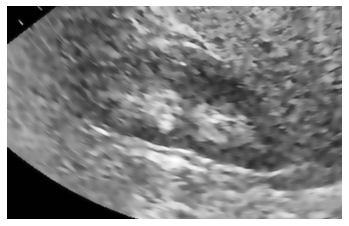

In [6]:
# Generate a random index
random_index = np.random.randint(0, len(data_records["images"]))

# Plot the random image
plt.imshow(data_records["images"][random_index], cmap="gray")

plt.axis("off")
plt.show()

In [7]:
import os
import random


# Get list of image filenames in the directory
directory = "og/"
image_filenames = os.listdir(directory)

random_image_filename = random.choice(image_filenames)
random_image_path = os.path.join(directory, random_image_filename)
random_image = plt.imread(random_image_path)
plt.imsave("ultrasound_scan.jpg", random_image, cmap="gray")


### GLCM features

In [8]:
from skimage.feature import graycomatrix, graycoprops


# Define function to compute GLCM features for a single image
def compute_glcm_features(image):

    image = image.astype(np.uint8)
    distances = [1, 2, 3]  # Define distances for GLCM computation
    angles = [
        0,
        np.pi / 4,
        np.pi / 2,
        3 * np.pi / 4,
    ]  # Define angles for GLCM computation
    glcm = graycomatrix(
        image, distances=distances, angles=angles, symmetric=True, normed=True
    )
    # print(glcm.shape)
    # Compute GLCM properties
    # Contrast measures the local variations in pixel intensities and is computed as the sum of squared differences between the intensity values in the GLCM.
    # Energy measures the uniformity of pixel intensities and is computed as the sum of squared GLCM values.
    # Homogeneity measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal and is computed as the sum of squared reciprocal distances.
    # Correlation measures the linear dependency between the intensity values in the GLCM and is computed as the covariance of the GLCM values normalized by the standard deviations of the individual GLCM values.
    contrast = graycoprops(glcm, "contrast").ravel()
    energy = graycoprops(glcm, "energy").ravel()
    homogeneity = graycoprops(glcm, "homogeneity").ravel()
    correlation = graycoprops(glcm, "correlation").ravel()

    # Concatenate GLCM features
    glcm_features = np.concatenate([contrast, energy, homogeneity, correlation])
    return glcm_features

In [9]:
images = df["images"].values[1]

# glcm_features = [compute_glcm_features(image.astype(np.uint8)) for image in images]
glcm_features = compute_glcm_features(images.astype(np.uint8))

print(f"Dimension of feature matrix of one image: {glcm_features.shape}")

Dimension of feature matrix of one image: (48,)


The other options in GLCM is dissimilarity and ASM

Here, we are trying to find the similarity and is handled by correlation. Dissimilarity often would produce noise or irrelevant information.
ASM at times is not often used for finding subtle differences. we concentrate on the subtle details for detecting liver steatosis.
Since these two contribute less to the model's performance, and it would **take more time to compute** these, it was decided that these features can be omitted. Even after adding them performance did not seem to improve, rather got worse.

Different angles and distance were also tried, to finally settle on these.

Each element in the `glcm_features` is the value calculated using a distance and an angle: this gives the relation between the pixels at the givn angle and distance

In [10]:
images = df["images"].values

print(
    f"Dimension of glcm feature of one image: {compute_glcm_features(images[0].astype(np.uint8)).shape}"
)
# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image.astype(np.uint8)) for image in images]

# Concatenate GLCM features into a feature matrix
feature_matrix = np.array(glcm_features)
print(f"Dimension of feature matrix: {feature_matrix.shape}")

Dimension of glcm feature of one image: (48,)
Dimension of feature matrix: (550, 48)


## GLCM Theory
### Co-occurence matrix calculation

Dimension of `glcm` is (256, 256, 3, 4) = (number of grey levels, n of grey levels, n of distances, n of angles)


There are 256 grey levels because the range of greyscale is 0-256. (it is set in the `levels` argument in graycomatrix fn. The `levels` param should be greater than the max grey value)

A co-occ matrix is calculated for one (dist, angle) pair. So `glcm` is a collection of all 12 matrices for each combination of angles and dist (4*3). Each co-occ matrix is of size 255x255

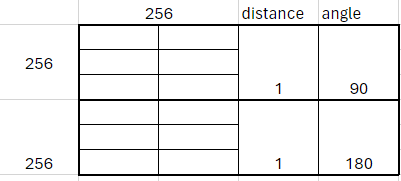

### Feature Calculation
Then the 4 properties are calculated: energy, contrast, homogeniety, similarity.

Each property calculates one value per matrix. So there will be 12 values (because of 12 matrices) for one property.

Since there are 4 properties, there will be 12*4=48 values for an image (as a vector)

So, `glcm_features` is of size (48,)

`feature_matrix` is concatenation of `glcm_features` of each image. Since we have 550 images, the dimension is (550, 48)

Now, we have come down from size of (550, 868, 1272) for original image to (550, 400, 630) for region of interest to (550, 48)


In [11]:
y = df["class"]

In [12]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [13]:
def display_results(metrics):
    
    print("Mean Accuracy:", metrics["mean_accuracy"])
    print("Mean ROC-AUC Score:", metrics["mean_auc"])
    print("Mean Confusion Matrix:\n", metrics["mean_conf_matrix"])
    print("Mean Classification Report:\n", metrics["classification_report"])

    class_names = ["No Disease", "Disease"]
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        metrics["mean_conf_matrix"],
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [14]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


def get_rfc_with_pca(X, y, pca, num_folds=7):

    # Define the number of folds for cross-validation
    metrics = {}
    accuracy_scores = []
    auc_scores = []
    conf_matrices = []
    classification_reports = []

    # Initialize a StratifiedKFold object
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )

    # Perform cross-validation
    for train_index, test_index in kf.split(X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA to the training and test data
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train the classifier
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate ROC-AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Calculate classification report
        cls_report = classification_report(y_test, y_pred)
        classification_reports.append(cls_report)

    metrics['mean_accuracy']  = np.mean(accuracy_scores) 
    metrics['best_accuracy'] = max(accuracy_scores)
    metrics['mean_auc'] = np.mean(auc_scores)
    metrics['mean_conf_matrix'] = np.mean(conf_matrices, axis=0)
    metrics['classification_report'] = classification_reports[0]
    
    display_results(metrics)


    return clf

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


def get_rfc_with_pca(X, y, pca, num_folds=7):

    # Define the number of folds for cross-validation
    metrics = {}
    accuracy_scores = []
    auc_scores = []
    conf_matrices = []
    classification_reports = []

    # Initialize a StratifiedKFold object
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )

    # Perform cross-validation
    for train_index, test_index in kf.split(X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA to the training and test data
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train the classifier
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate ROC-AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Calculate classification report
        cls_report = classification_report(y_test, y_pred)
        classification_reports.append(cls_report)

    metrics['mean_accuracy']  = np.mean(accuracy_scores) 
    metrics['best_accuracy'] = max(accuracy_scores)
    metrics['mean_auc'] = np.mean(auc_scores)
    metrics['mean_conf_matrix'] = np.mean(conf_matrices, axis=0)
    metrics['classification_report'] = classification_reports[0]
    
    display_results(metrics)


    return clf

In [15]:
def display_conf_matrix(conf_matrix):
    # Plot the confusion matrix
    class_names = ["No Disease", "Disease"]
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        conf_matrix,
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

PCA(MLE) gives better accuracy and stuff that any other methods

Mean Accuracy: 0.9454319362153463
Mean ROC-AUC Score: 0.9071428571428571
Mean Confusion Matrix:
 [[14.71428571  3.28571429]
 [ 0.14285714 44.71428571]]
Mean Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.92      1.00      0.96        45

    accuracy                           0.94        63
   macro avg       0.96      0.89      0.92        63
weighted avg       0.94      0.94      0.93        63



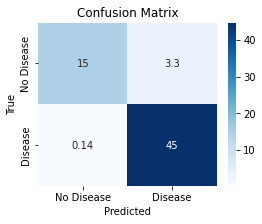

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, y, test_size=0.2, random_state=42
)
# Initialize a PCA object
pca = PCA(n_components="mle")
model = get_rfc_with_pca(X_train, y_train, pca, 7)

# Mean Accuracy: 0.9454319362153463
# Best Accuracy: 0.9841269841269841
# Mean ROC-AUC Score: 0.9071428571428571
# Mean Confusion Matrix:
#  [[14.71428571  3.28571429]
#  [ 0.14285714 44.71428571]]

Test Accuracy: 0.9


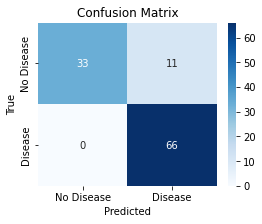

In [17]:
pca.fit_transform(X_train)
X_test = pca.transform(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

display_conf_matrix(conf_matrix)

Choosing `min_samples_split = 5` and `number of folds = 7` is a good approach because it results in a balanced and reliable model, as shown in the table's performance metrics. The Mean Accuracy is high (0.94), indicating that the model is making correct predictions most of the time. The Mean ROC-AUC Score of 0.9 signifies a strong capability to differentiate between classes, showing effective classification.

Regarding Precision, Recall, and F1 Score, the values are impressive for both classes. Specifically, for class 0, the Precision is 1.0, and Recall is 0.98, indicating it rarely misclassifies. For class 1, the Precision is 0.92, and Recall is 1.0, indicating it effectively identifies cases in this class. This combination of high precision and recall results in a good F1 Score and Test Accuracy, suggesting that this configuration performs well even with unseen data.

In [18]:
#joblib library, which provides functions for saving and loading Python objects to and from disk.
import joblib

# Save the trained model and PCA preprocessor
joblib.dump(model, r"..\models\trained_model.pkl")
joblib.dump(pca, r"..\models\pca_preprocessor.pkl")

['..\\models\\pca_preprocessor.pkl']

In [19]:

loaded_model = joblib.load(r"..\models\trained_model.pkl")
loaded_pca = joblib.load(r"..\models\pca_preprocessor.pkl")

In [20]:
def preprocess_img(image_data, l_pca=pca):
    input_img = cv2.imread(image_data, cv2.CV_8UC1)
    enhanced_img = enhance_image(input_img)
    roi_img = enhanced_img[300:700, 170:800]

    glcm_features = compute_glcm_features(roi_img)
    pca_features = l_pca.transform([glcm_features])

    return pca_features

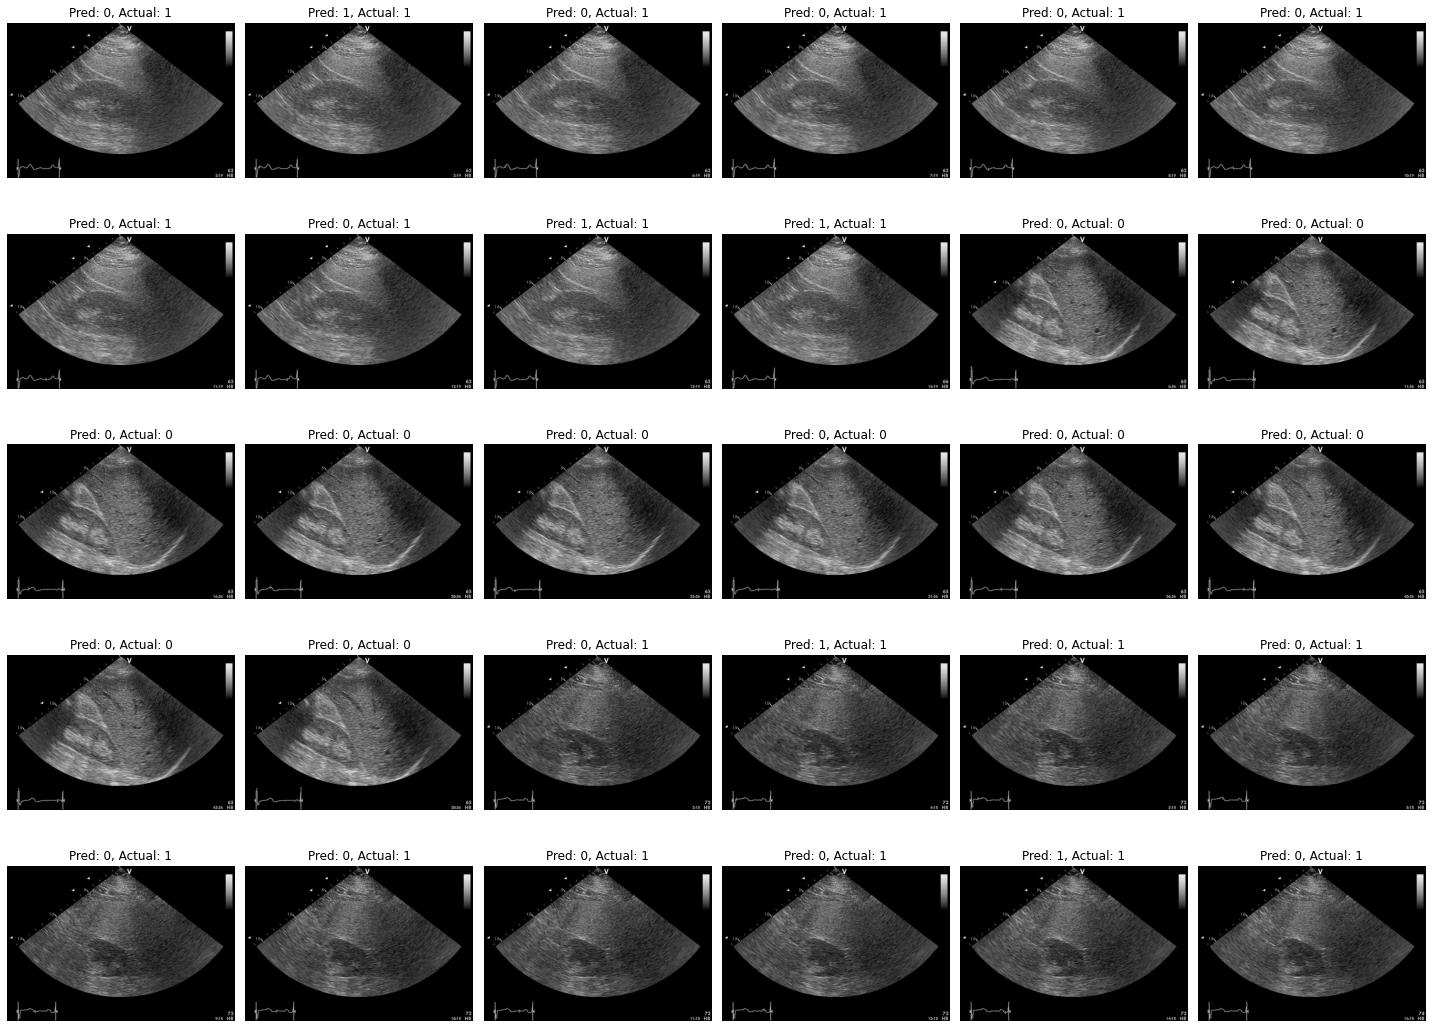

In [21]:
import matplotlib.pyplot as plt
import os

directory = r"og"


def get_actual_value(filename):
    return int(filename.split("_")[1])


plt.figure(figsize=(20, 15))

image_count = 0

for idx, filename in enumerate(os.listdir(directory)[90:120], start=1):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        new_features_pca = preprocess_img(filepath)
        prediction = loaded_model.predict(new_features_pca)
        actual_value = get_actual_value(filename)

        img = plt.imread(filepath)
        plt.subplot(5, 6, idx)
        plt.imshow(img)
        plt.title(f"Pred: {prediction[0]}, Actual: {actual_value}")
        plt.axis("off")

        image_count += 1

plt.tight_layout()
plt.show()